In [1]:
import json
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

In [8]:
def flatten(list_of_list):
    return [item for sublist in list_of_list for item in sublist]

def read_transcription(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

def create_dataframe(dialogue_id, transcription):
    rows = []

    # Iterate through all sentences in the transcription
    for index, sentence in enumerate(transcription):
        speaker = sentence['speaker']

        # Get the sentence text
        text = sentence['text']

        # Add a row to the DataFrame
        rows.append({
            'dialogue_id': dialogue_id,
            'index_start': index,
            'text': text,
            'speaker_text': speaker,
        })

    # Create the DataFrame
    df = pd.DataFrame(rows)

    return df

# Function to get labels for a dialogue
def get_label(dialogue_id, index,labels_data):
    return labels_data.get(dialogue_id, [])[index]

In [4]:
# Remplacez 'votre_chemin' par le chemin correct
path_train= Path("data/training")
path_test= Path("data/test")

# Remplacez 'vos_dialogue_ids' par votre liste réelle d'identifiants de dialogue
training_set = ['ES2002', 'ES2005', 'ES2006', 'ES2007', 'ES2008', 'ES2009', 'ES2010', 'ES2012', 'ES2013', 'ES2015', 'ES2016', 'IS1000', 'IS1001', 'IS1002', 'IS1003', 'IS1004', 'IS1005', 'IS1006', 'IS1007', 'TS3005', 'TS3008', 'TS3009', 'TS3010', 'TS3011', 'TS3012']
training_set = flatten([[m_id+s_id for s_id in 'abcd'] for m_id in training_set])
training_set.remove('IS1002a')
training_set.remove('IS1005d')
training_set.remove('TS3012c')

test_set = ['ES2003', 'ES2004', 'ES2011', 'ES2014', 'IS1008', 'IS1009', 'TS3003', 'TS3004', 'TS3006', 'TS3007']
test_set = flatten([[m_id+s_id for s_id in 'abcd'] for m_id in test_set])

In [9]:
# Créer le DataFrame pour l'ensemble d'entraînement
dfs = []
for dialogue_id in training_set:
    transcription_data = read_transcription(path_train / f'{dialogue_id}.json')
    df = create_dataframe(dialogue_id, transcription_data)
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)

# Ajouter la colonne 'label' à df en utilisant la fonction get_label
with open("data/training_labels.json", 'r') as file:
    labels_data = json.load(file)

df['label'] = df.apply(lambda row: get_label(row['dialogue_id'], row['index_start'], labels_data), axis=1)

# Créer le DataFrame pour l'ensemble de test
dfs_test = []
for dialogue_id in test_set:
    transcription_data = read_transcription(path_test / f'{dialogue_id}.json')
    df_test = create_dataframe(dialogue_id, transcription_data)
    dfs_test.append(df_test)

df_test = pd.concat(dfs_test, ignore_index=True)

In [16]:
df.head()

,dialogue_id,index_start,text,speaker_text,label
0,ES2002a,0,Okay,PM,0
1,ES2002a,1,Right,PM,0
2,ES2002a,2,<vocalsound> Um well this is the kick-off meet...,PM,1
3,ES2002a,3,Um <vocalsound> and um,PM,0
4,ES2002a,4,this is just what we're gonna be doing over th...,PM,0


In [14]:
df_test.shape

(31026, 4)

In [7]:
df['bert'] = df['text']
for transcription_id in training_set:
    bert_array = np.load('feature_bert/training/' + transcription_id + '.npy')
    
    # Obtenez les indices des lignes correspondant à la transcription_id
    indices = df[df['dialogue_id'] == transcription_id].index
    
    # Remplacez les valeurs de la colonne 'text' par les valeurs de bert_array
    for idx, value in enumerate(bert_array):
        df.at[indices[idx-1], 'bert'] = value

df_test['bert'] = df_test['text']
for transcription_id in test_set:
    bert_array_test = np.load('feature_bert/test/' + transcription_id + '.npy')
    
    # Obtenez les indices des lignes correspondant à la transcription_id
    indices = df_test[df_test['dialogue_id'] == transcription_id].index
    
    # Remplacez les valeurs de la colonne 'text' par les valeurs de bert_array
    for idx, value in enumerate(bert_array_test):
        df_test.at[indices[idx-1], 'bert'] = value


In [8]:
# Nombre d'éléments dans chaque liste
num_elements = len(df['bert'].iloc[0])

# Créez de nouvelles colonnes pour chaque élément dans la liste
new_columns = [f'coord_{i}' for i in range(num_elements)]

# Appliquez une fonction qui divise chaque liste en plusieurs colonnes
new_text_columns = df['bert'].apply(pd.Series)

# Renommez les nouvelles colonnes avec les noms spécifiques
new_text_columns.columns = new_columns

# Concaténez les nouvelles colonnes avec le DataFrame existant
df = pd.concat([df, new_text_columns], axis=1)


# Nombre d'éléments dans chaque liste
num_elements = len(df_test['bert'].iloc[0])

# Appliquez une fonction qui divise chaque liste en plusieurs colonnes
new_text_columns_test = df_test['bert'].apply(pd.Series)

# Renommez les nouvelles colonnes avec les noms spécifiques
new_text_columns_test.columns = new_columns

# Concaténez les nouvelles colonnes avec le DataFrame existant
df_test = pd.concat([df_test, new_text_columns_test], axis=1)


In [42]:
df.head()

,dialogue_id,index_start,text,index_end,speaker_type,speaker_text,relation_type,relation_text,label,bert,...,coord_375,coord_376,coord_377,coord_378,coord_379,coord_380,coord_381,coord_382,coord_383,nb_long_words
0,ES2002a,0,Okay,1.0,2,PM,12.0,Continuation,0,"[-0.054861926, 0.047606602, -0.032625835, -0.0...",...,0.034839,-0.021490,0.007297,0.027587,0.027128,0.145950,0.037911,0.073511,0.079932,0
1,ES2002a,1,Right,2.0,2,PM,12.0,Continuation,0,"[-0.054665036, -0.073837034, -0.017160872, -0....",...,0.098955,-0.025984,0.077994,0.003580,0.032260,0.022304,0.059096,-0.036019,-0.008820,0
2,ES2002a,2,<vocalsound> Um well this is the kick-off meet...,3.0,2,PM,10.0,Explanation,1,"[-0.010415948, -0.072719134, -0.017205587, -0....",...,0.032185,0.010955,0.041298,-0.018026,0.050856,0.007696,0.041694,0.077368,-0.037393,4
3,ES2002a,3,Um <vocalsound> and um,4.0,2,PM,1.0,Elaboration,0,"[-0.028653603, -0.01515074, 0.095909655, -0.05...",...,0.061266,-0.011521,-0.010543,0.010692,0.117780,-0.017561,-0.028903,0.007401,-0.005552,1
4,ES2002a,4,this is just what we're gonna be doing over th...,5.0,2,PM,12.0,Continuation,0,"[-0.028386272, -0.046021443, 0.023957256, -0.0...",...,-0.023915,-0.037931,0.040358,0.079421,-0.018038,0.041037,0.034134,0.028470,-0.012039,2


In [9]:
# Compter le nombre d'occurrences de chaque dialogue_id_index_start
comment_counts = df.groupby(['dialogue_id', 'index_start']).size().reset_index(name='occurrence')

# Ajouter la colonne 'label' au DataFrame
comment_counts['label'] = df.groupby(['dialogue_id', 'index_start'])['label'].first().values

# Afficher le nouveau DataFrame
print(comment_counts)

      dialogue_id  index_start  occurrence  label
0         ES2002a            0           1      0
1         ES2002a            1           1      0
2         ES2002a            2           1      1
3         ES2002a            3           1      0
4         ES2002a            4           1      0
...           ...          ...         ...    ...
53386     TS3012d         1277           1      0
53387     TS3012d         1278           1      0
53388     TS3012d         1279           2      0
53389     TS3012d         1281           1      0
53390     TS3012d         1282           1      0

[53391 rows x 4 columns]


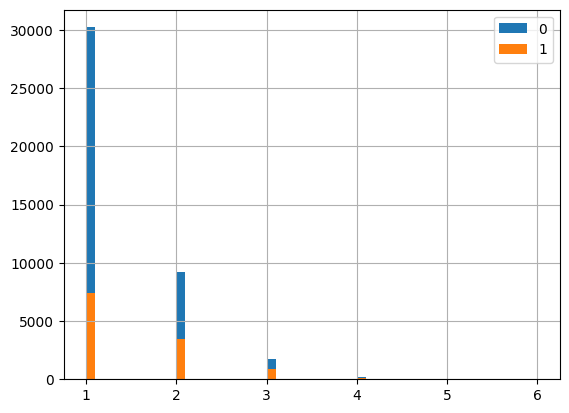

In [10]:
comment_counts[comment_counts['label'] == 0]['occurrence'].hist(bins=50, label='0')
comment_counts[comment_counts['label'] == 1]['occurrence'].hist(bins=50, label='1')
plt.legend()
plt.show()

In [41]:
df['nb_long_words'] = df['text'].apply(lambda x: sum(len(word) >= 6 for word in x.split(" ")))

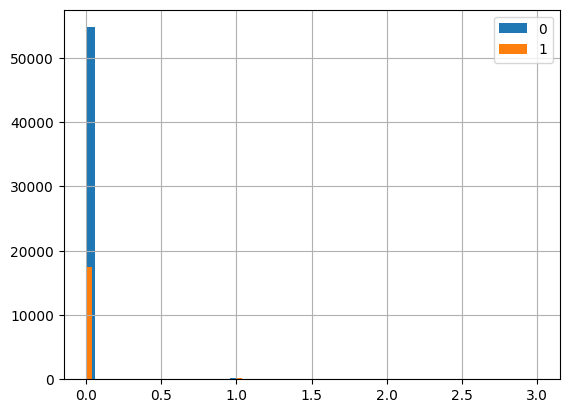

In [40]:
df[df['label'] == 0]['nb_long_words'].hist(bins=50, label='0')
df[df['label'] == 1]['nb_long_words'].hist(bins=50, label='1')
plt.legend()
plt.show()